In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


In [25]:
data_train_path = 'solid_dry_waste/train'
data_test_path = 'solid_dry_waste/test'
data_val_path = 'solid_dry_waste/validation'

In [26]:
img_width = 180
img_height =180 

In [27]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False)

Found 69 files belonging to 2 classes.


In [28]:
data_cat = data_train.class_names

In [29]:
data_cat

['paper', 'plastic']

In [30]:
data_val = tf.keras.utils.image_dataset_from_directory(data_val_path,
                                                       image_size=(img_height,img_width),
                                                       batch_size=32,
                                                        shuffle=False,
                                                       validation_split=False)

Found 11 files belonging to 2 classes.


In [31]:
data_test = tf.keras.utils.image_dataset_from_directory(
data_test_path,
    image_size=(img_height,img_width),
    shuffle=False,
    batch_size=32,
    validation_split=False
)

Found 11 files belonging to 2 classes.


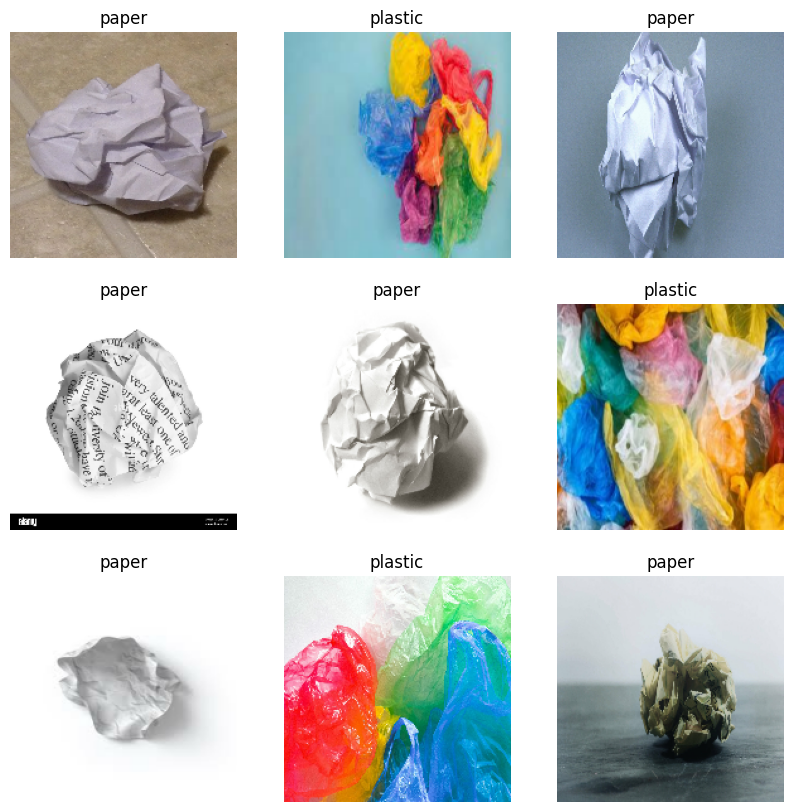

In [32]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

In [33]:
from tensorflow.keras.models import Sequential

In [34]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [35]:
model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128),
    layers.Dense(len(data_cat))
                  
])

In [36]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [37]:
epochs_size = 25
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size)

Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4930 - loss: 6.3879 - val_accuracy: 0.3636 - val_loss: 0.9663
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.4004 - loss: 1.0778 - val_accuracy: 0.9091 - val_loss: 0.5113
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.9102 - loss: 0.4258 - val_accuracy: 0.8182 - val_loss: 0.3249
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.8148 - loss: 0.4201 - val_accuracy: 0.9091 - val_loss: 0.2945
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.9621 - loss: 0.2539 - val_accuracy: 1.0000 - val_loss: 0.1270
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.9096 - loss: 0.2328 - val_accuracy: 1.0000 - val_loss: 0.0882
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.9621 - loss: 0.1304 - val_accuracy: 1.0000 - val_loss: 0.0476
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.9699 - loss: 0.0788 - val_accuracy: 1.0000 - val_loss: 0

Text(0.5, 1.0, 'Loss')

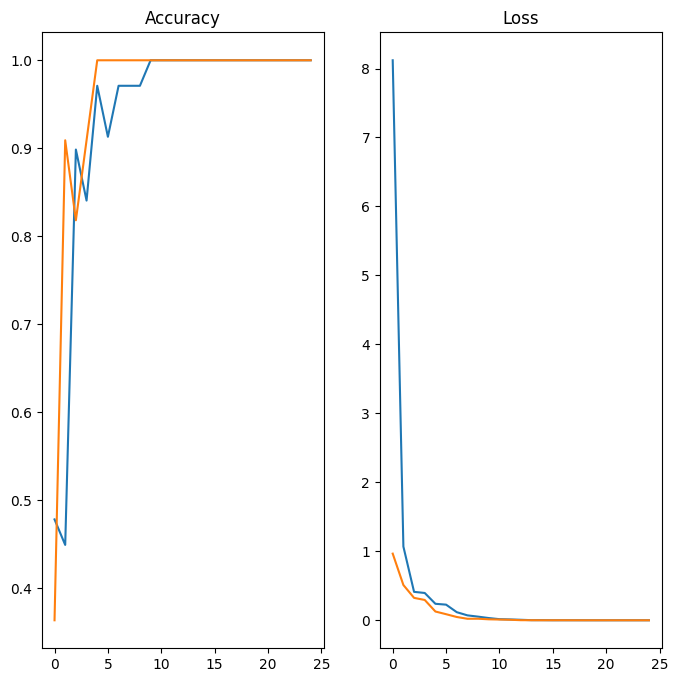

In [38]:
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')

In [39]:
image = 'plastic.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [40]:
predict = model.predict(img_bat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


In [41]:
score = tf.nn.softmax(predict)

In [42]:
print('Veg/Fruit in image is {} with accuracy of {:0.2f}'.format(data_cat[np.argmax(score)],np.max(score)*100))

Veg/Fruit in image is plastic with accuracy of 100.00


In [43]:
model.save('C:/Users/James/OneDrive/Desktop/EcoMend/Image_classify.keras', save_format='keras')

